# Attention and Transformer

This week you learned about the attention mechanism, which is the backbone of one of the most transformative architecures in deep learning, i.e. Transformers. Although the conecpt and mechanism of attention was first introduced as an enhancing add-on to RNNs, Transformers introduced them as standalone sequence processors. The paper [Attention is All you Need](https://arxiv.org/pdf/1706.03762) has the details, and you are strongly encouraged to read it. There are also numerous blog posts and lectures about it. In this session, we will investigate what functions and modules PyTorch offers for attention and Transformer. Please read the documentation of each function or module carefully, since there are some inconsistensies about the shape notations and how the boolean masks work!

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

## [`F.scaled_dot_product_attention`](https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html)
$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) V
$$
In the figure and code, $E_k$ is the same as $d_k$ from the formula in the paper.

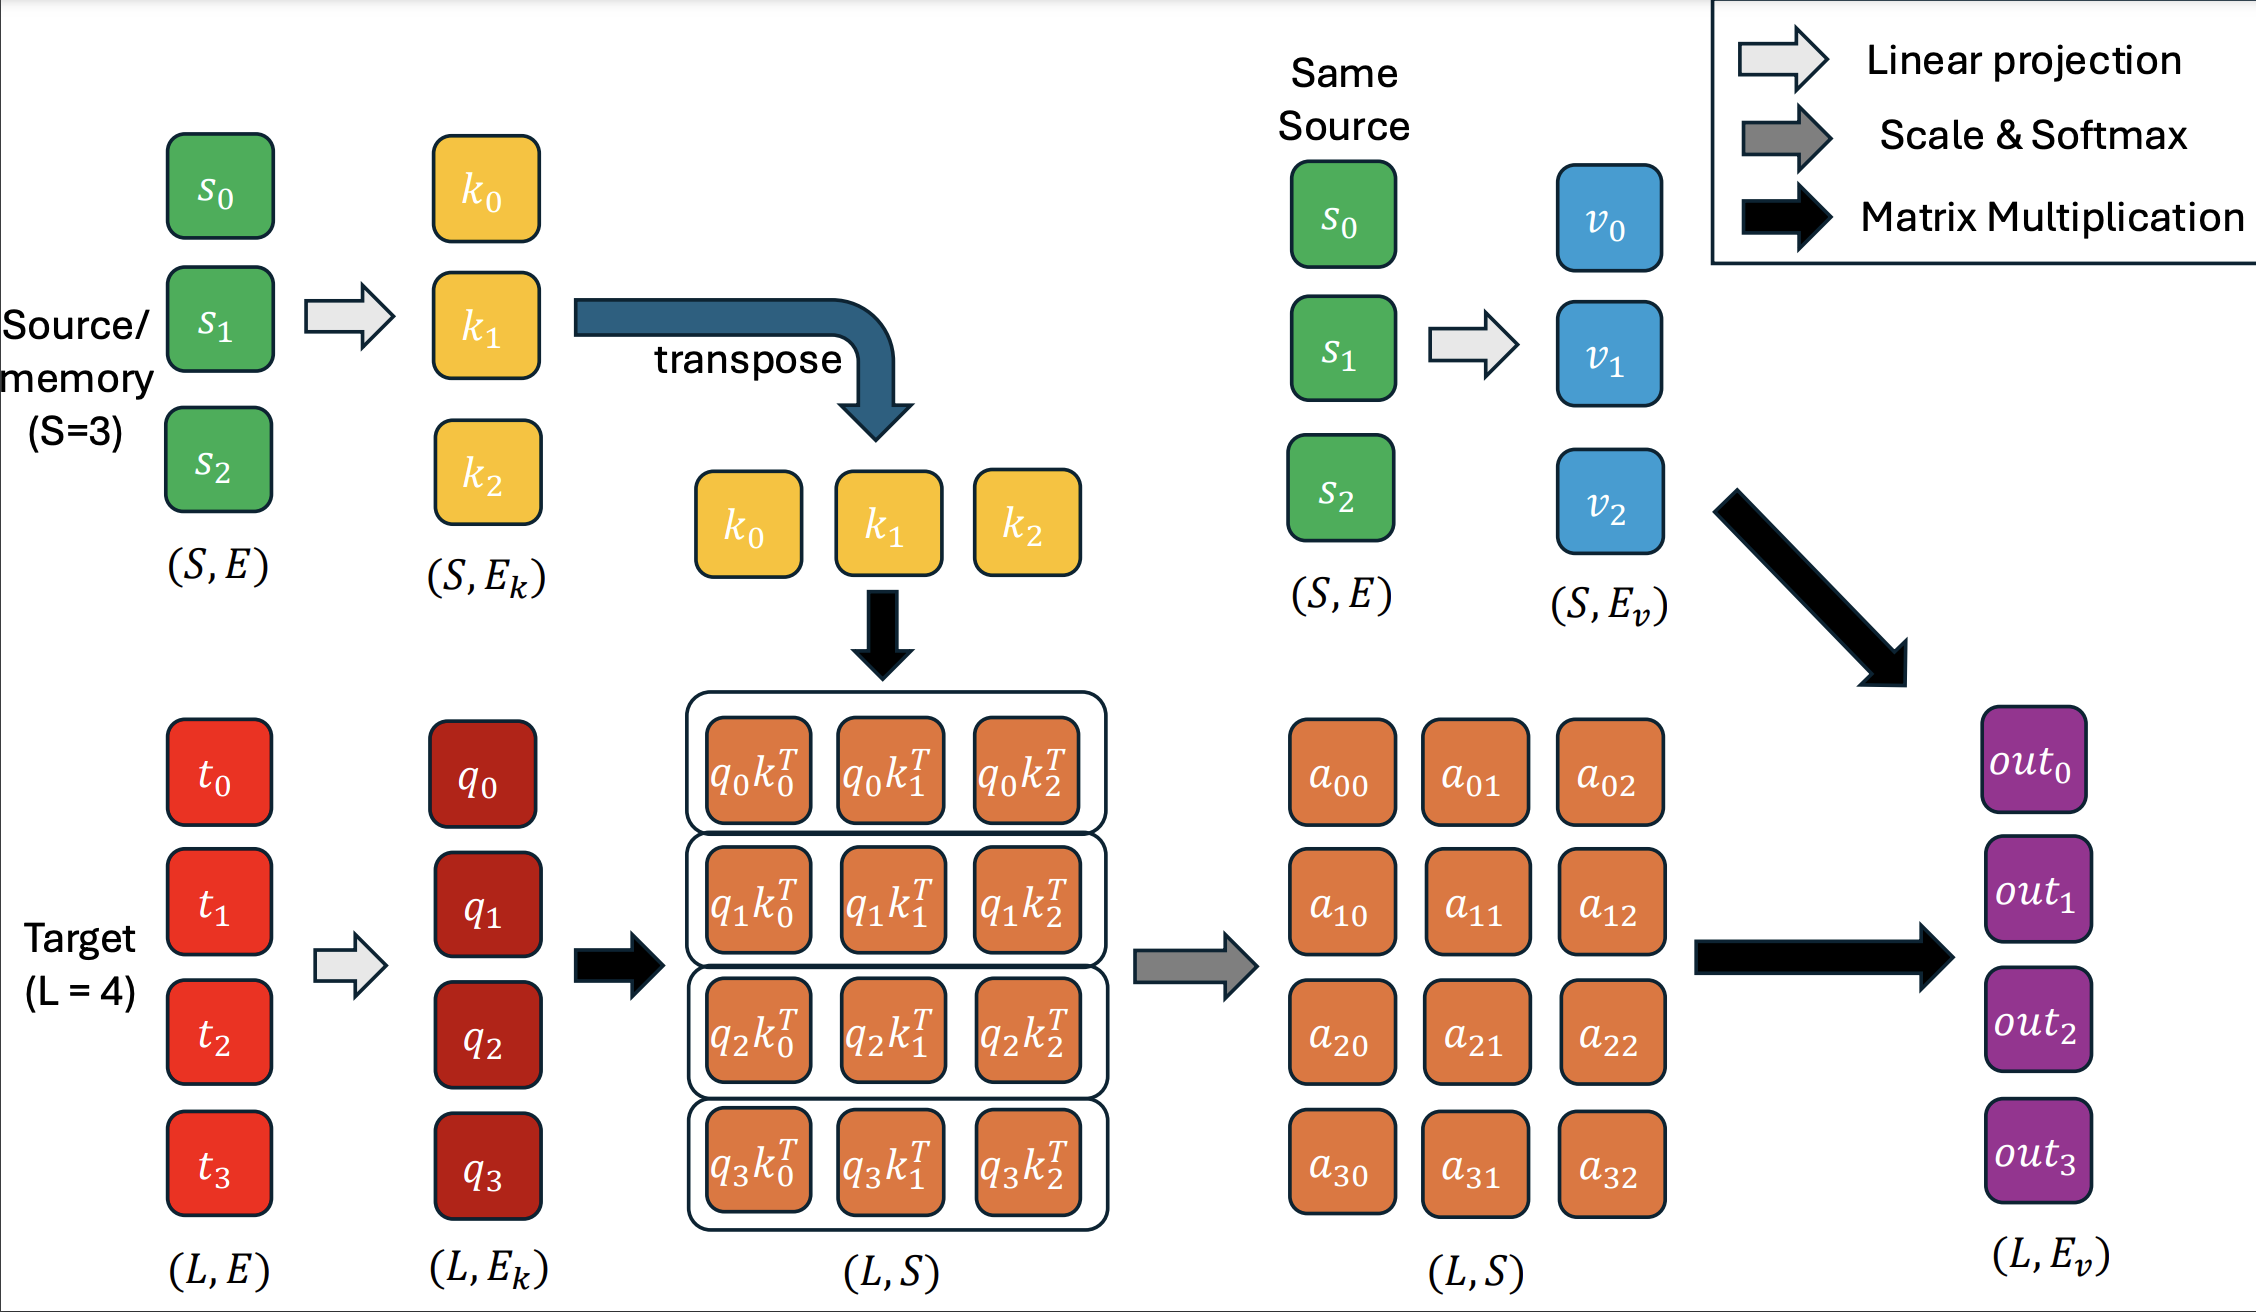

In [2]:
N = 3 # batch size
S = 3 # source sequence length
L = 5 # target sequence length
E = 11 # embedding dimension of query and key
Ev = 13 # embedding dimension of value
Hq = 4 # number of heads for query
H = 4 # number of heads for key and value

query = torch.randn(N, Hq, L, E)
key = torch.randn(N, H, S, E)
value = torch.randn(N, H, S, Ev)

output = F.scaled_dot_product_attention(
    query = query,
    key = key,
    value = value,
    attn_mask = None, # attention is omitted where False
    is_causal = False,
    scale = None,
)

print(output.shape) # (N, Hq, L, Ev)

torch.Size([3, 4, 5, 13])


In this function, `attn_mask` can be either float (to be added to the attention matrix), or boolean. If boolean, the attention is omitted for elements with a corresponding `False` in the mask. Be careful about this, since the modules in `nn` work in the opposite way, which is confusing!

In [3]:
# causal mask
causal_attn_mask = torch.ones(L, S, dtype=torch.bool).tril()
print(causal_attn_mask)

tensor([[ True, False, False],
        [ True,  True, False],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]])


In [4]:
masked_output = F.scaled_dot_product_attention(
    query = query,
    key = key,
    value = value,
    attn_mask = None, # attention is omitted where False
    is_causal = True,
    scale = None,
)

print(masked_output.shape) # (N, Hq, L, Ev)

torch.Size([3, 4, 5, 13])


Read the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html) to learn about more novel implementations like Flash-Attention, Memory-Efficient Attention, Grouped Query Attention (GQA), etc.

Small note about GQA: several different key/value heads correspond to the same query head. This is primarily for memory optimization and used in Large Language Models.

## [`nn.MultiHeadAttention`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html)
$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h) W^O \\
\text{where } \text{head}_i = \text{Attention}(Q W_i^Q, K W_i^K, V W_i^V)
$$

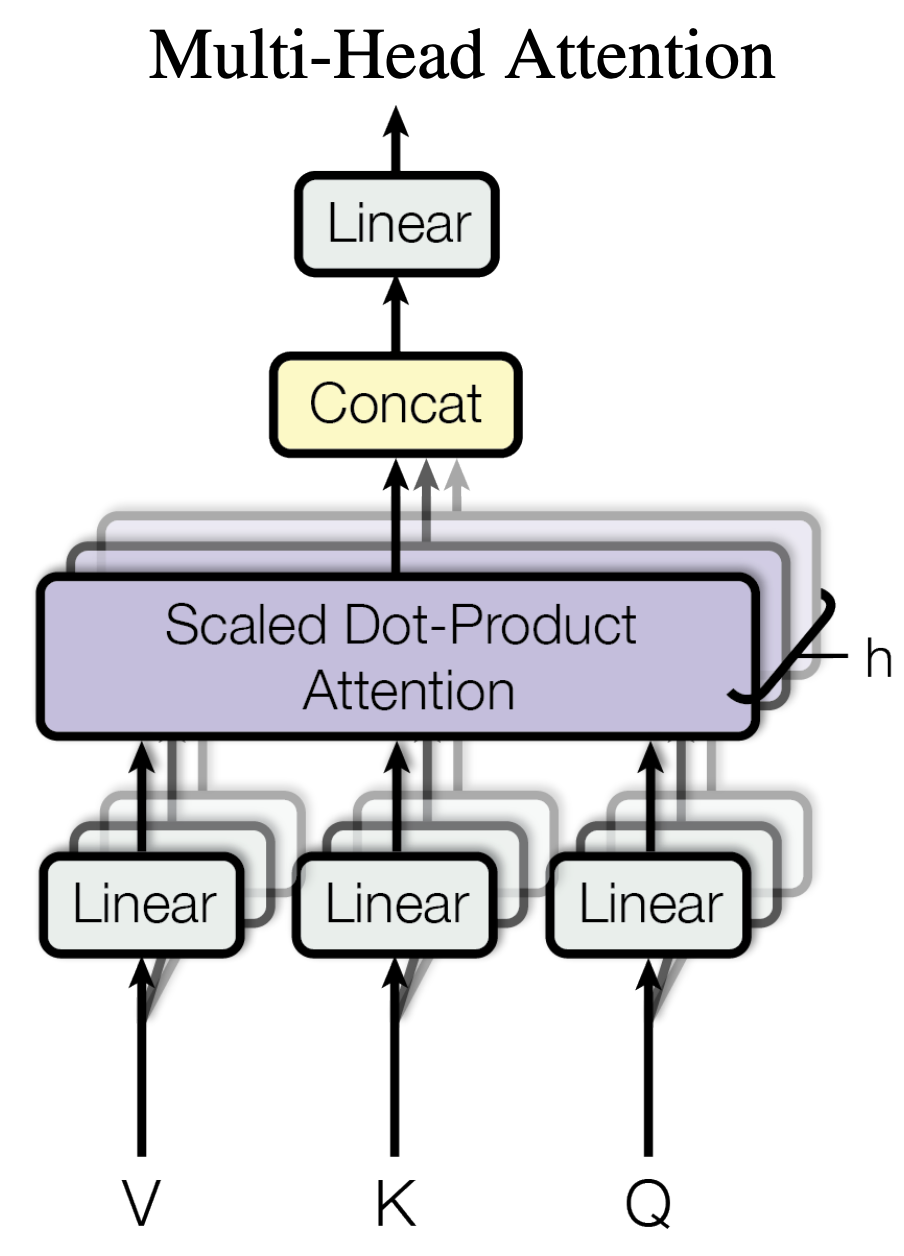

Although this module is flexible to take three different sequences, one for each of the input to query, key, and value matrices, usually the same source is used to get the key and value matrices. Another thing to be careful about is the dimension of the input to the query projector is assumed to be the same as the projected dimension of the query.

In [5]:
# data
N = 3 # batch size
S = 5 # source sequence length
L = 7 # target sequence length
Eq = 32 # embedding dimension of the query (target)
Ek = 13 # embedding dimension of the key (source)
Ev = 17 # embedding dimension of the value (source)

target_query = torch.randn(N, L, Eq)
source_key = torch.randn(N, S, Ek)
source_value = torch.randn(N, S, Ev)

# model embed_dim is assumed to be the same as Eq in this module!
embed_dim = Eq

multihead_attention = nn.MultiheadAttention(
    embed_dim = embed_dim,
    num_heads = 4,
    dropout = 0.0,
    bias = False,
    add_bias_kv = False,
    add_zero_attn = False,
    kdim = Ek,
    vdim = Ev,
    batch_first = True,
    )

print('The multihead attention module:')
print(50*'-')
print(multihead_attention)
print(50*'='+'\n')

print('The parameters of the multihead attention module:')
print(50*'-')
for name, param in multihead_attention.named_parameters():
    print(name, tuple(param.shape))

The multihead attention module:
--------------------------------------------------
MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=False)
)

The parameters of the multihead attention module:
--------------------------------------------------
q_proj_weight (32, 32)
k_proj_weight (32, 13)
v_proj_weight (32, 17)
out_proj.weight (32, 32)


As previously mentioned, in the `nn` modules, the boolean mask is interpreted in the opposite way of `F.scaled_dot_product_attention`. Here, the attention is omitted for elements with a corresponding `True` in the mask. Another possibly confusing difference here is that you still have to pass the mask if it is causal, and the `is_causal` argument does not take care of that for you! It is simply a hint that the mask is causal.

In [6]:
attn_mask = torch.ones(L, S, dtype=torch.bool).tril(diagonal=0).logical_not()
print(attn_mask)

tensor([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]])


In [7]:
mha_output, attn_weights = multihead_attention(
    query = target_query, 
    key = source_key, 
    value = source_value, 
    key_padding_mask = None, 
    need_weights = True, 
    attn_mask = None,
    average_attn_weights = True, 
    is_causal = False,
    )

print(mha_output.shape) # (L, N, Eq)
print(attn_weights.shape) # (N, L, S)

torch.Size([3, 7, 32])
torch.Size([3, 7, 5])


## [`nn.TransformerEncoderLayer`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer)

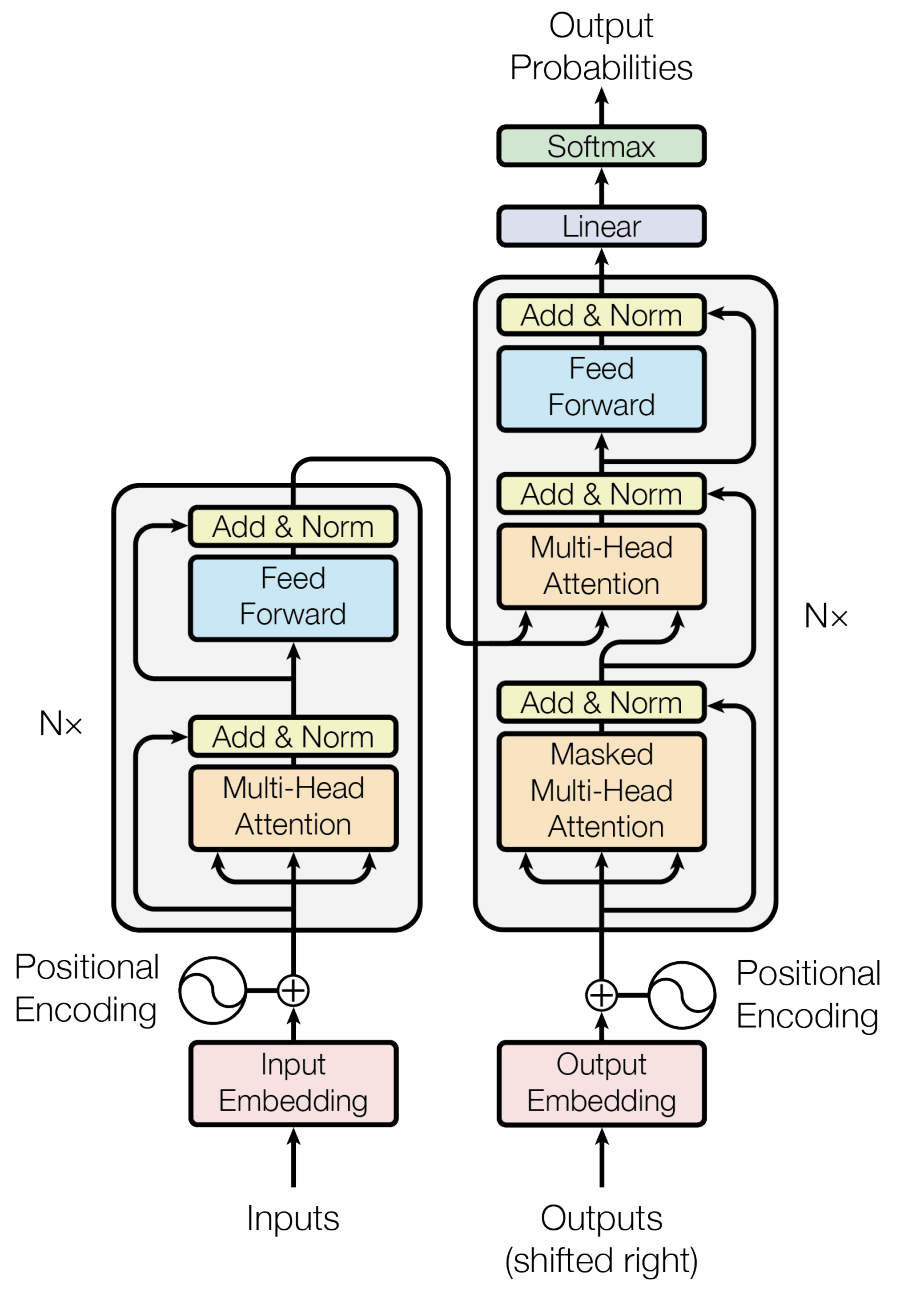

In [8]:
# data
N = 3 # batch size
S = 5 # source sequence length
d_model = 32 # feature dimension

# layer
nhead = 4

encoder_layer = nn.TransformerEncoderLayer(
    d_model = d_model, 
    nhead = nhead, 
    dim_feedforward = 64, 
    dropout = 0.0, 
    activation = 'relu', 
    layer_norm_eps = 1e-05, 
    batch_first = True, 
    norm_first = False, 
    bias = False,
    )

source = torch.randn(N, S, d_model)

print('The encoder layer:')
print(50*'-')
print(encoder_layer)
print(50*'='+ '\n')

print('Parameters of the encoder layer:')
print(50*'-')
for pname, pvalue in encoder_layer.named_parameters():
    print(pname, tuple(pvalue.shape))

The encoder layer:
--------------------------------------------------
TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=False)
  )
  (linear1): Linear(in_features=32, out_features=64, bias=False)
  (dropout): Dropout(p=0.0, inplace=False)
  (linear2): Linear(in_features=64, out_features=32, bias=False)
  (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.0, inplace=False)
  (dropout2): Dropout(p=0.0, inplace=False)
)

Parameters of the encoder layer:
--------------------------------------------------
self_attn.in_proj_weight (96, 32)
self_attn.out_proj.weight (32, 32)
linear1.weight (64, 32)
linear2.weight (32, 64)
norm1.weight (32,)
norm2.weight (32,)


In [9]:
# mask for the attention matrix
src_mask = torch.ones(S, S, dtype=torch.bool).tril(diagonal=0)

# mask to indicate the pad tokens
src_key_padding_mask = torch.ones(N, S).bool()
src_key_padding_mask[0, 3:] = False
src_key_padding_mask[1, 2:] = False
src_key_padding_mask[2, 4:] = False

encoder_output = encoder_layer(
    src = source,
    src_mask = src_mask,
    src_key_padding_mask = src_key_padding_mask,
)

print('encoder output shape', encoder_output.shape) # (N, S, d_model)

encoder output shape torch.Size([3, 5, 32])


## [`nn.TransformerDecoderLayer`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoderLayer.html)

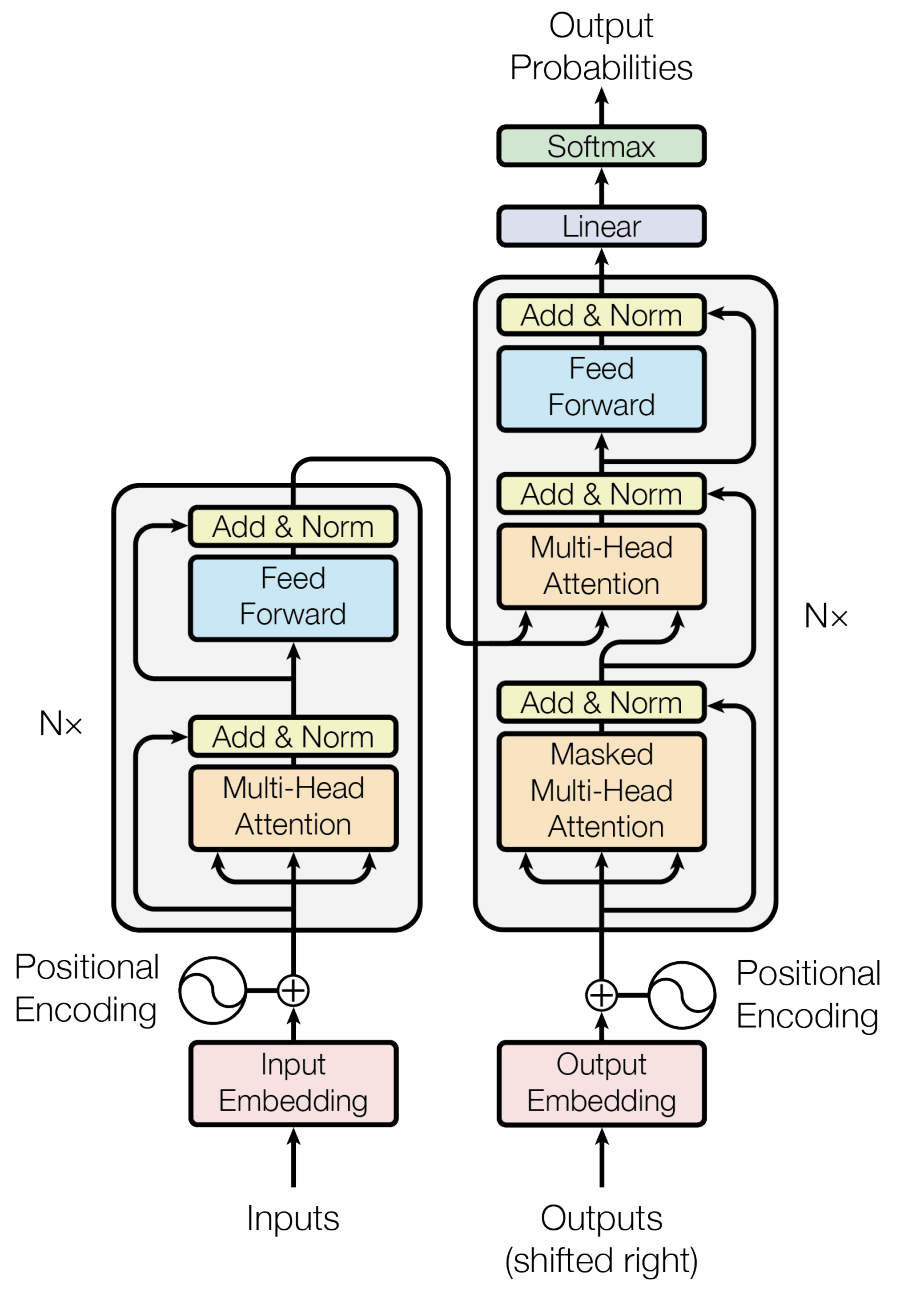

In [10]:
# data
N = 3 # batch size
S = 5 # source sequence length
L = 7 # target sequence length
d_model = 32 # feature dimension

# layer
nhead = 8
decoder_layer = nn.TransformerDecoderLayer(
    d_model = d_model, 
    nhead = nhead, 
    dim_feedforward = 64, 
    dropout = 0.0, 
    activation = 'relu', 
    layer_norm_eps = 1e-05, 
    batch_first = True, 
    norm_first = False, 
    bias = False,
    )

memory = torch.randn(N, S, d_model)
target = torch.randn(N, L, d_model)

print('The decoder layer:')
print(50*'-')
print(decoder_layer)
print(50*'='+ '\n')

print('Parameters of the decoder layer:')
print(50*'-')
for pname, pvalue in decoder_layer.named_parameters():
    print(pname, tuple(pvalue.shape))

The decoder layer:
--------------------------------------------------
TransformerDecoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=False)
  )
  (multihead_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=False)
  )
  (linear1): Linear(in_features=32, out_features=64, bias=False)
  (dropout): Dropout(p=0.0, inplace=False)
  (linear2): Linear(in_features=64, out_features=32, bias=False)
  (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (norm3): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.0, inplace=False)
  (dropout2): Dropout(p=0.0, inplace=False)
  (dropout3): Dropout(p=0.0, inplace=False)
)

Parameters of the decoder layer:
--------------------------------------------------
self_attn.in_proj_weight (96, 32)
self_attn.out_proj

In [11]:
decoder_output = decoder_layer(
    tgt = target,
    memory = memory,

    tgt_mask = None,
    memory_mask = None,

    tgt_key_padding_mask = None,
    memory_key_padding_mask = None,

    tgt_is_causal = False,
    memory_is_causal = False,
)

print(decoder_output.shape) # (N, L, d_model)

torch.Size([3, 7, 32])


## Putting all together

PyTorch has [`nn.TransformerEncoder`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder) which simply stacks several transformer encoder layers, and [`nn.TransformerDecoder`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoder.html#torch.nn.TransformerDecoder) which stacks a certain number of decoder layers. Each layer will have its distinct learnable parameters. Here's an example:

In [12]:
encoder = nn.TransformerEncoder(
    encoder_layer = encoder_layer,
    num_layers = 6,
    norm = None,
    enable_nested_tensor = False, # not sure what this is
)

decoder = nn.TransformerDecoder(
    decoder_layer = decoder_layer,
    num_layers = 6,
    norm = None,
)

Finally, let's look at [`nn.Transformer`](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html#torch.nn.Transformer):

In [13]:
N = 3 # batch size
S = 5 # source sequence length
T = 7 # target sequence length
E = 64 # embedding dimension

source = torch.randn(N, S, E)
target = torch.randn(N, T, E)


transformer = nn.Transformer(
    d_model = E, 
    nhead = 4, # E should be divisible by nhead
    num_encoder_layers = 2, 
    num_decoder_layers = 2, 
    dim_feedforward = 128, 
    dropout = 0.0, 
    activation = 'gelu', 
    custom_encoder = None, 
    custom_decoder = None, 
    layer_norm_eps = 1e-05, 
    batch_first = True, # Make sure to set this to True
    norm_first = True, 
    bias = False, 
    )

/home/pouya/anaconda3/envs/DL_TA/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [14]:
# Example masks:

source_mask = torch.ones(S, S, dtype=torch.bool).tril(diagonal=0).logical_not() # this is the causal mask
source_key_padding_mask = torch.ones(N, S).bool()

target_mask = torch.ones(L, L, dtype=torch.bool).tril(diagonal=0).logical_not() # this is a causal mask
target_key_padding_mask = torch.ones(N, L).bool()

transformer_output = transformer(
    src = source, 
    tgt = target, 

    # attention masks
    src_mask = None, # source self-attention mask of shape (S, S) or (N*nhead, S, S)
    tgt_mask = None, # target self-attention mask of shape (L, L) or (N*nhead, T, T)
    memory_mask = None, # cross-attention from target to memory (encoded source) of shape (T, S)

    # padding masks
    src_key_padding_mask = None, # for self-attention in the encoder on the source, of shape (N, S)
    tgt_key_padding_mask = None, # for self-attention in the decoder on the target, of shape (N, L)
    memory_key_padding_mask = None, # for cross-attention in the decoder on the memory (encoded source), of shape (N, S) 

    # causal masks (you can use either these or the attention masks, not both)
    src_is_causal = None,  # for self-attention in the encoder on the source,
    tgt_is_causal = None,  # for self-attention in the decoder on the target
    memory_is_causal = False, # for cross-attention in the decoder on the memory (encoded source)
    )

print(transformer_output.shape) # (N, T, E)

torch.Size([3, 7, 64])
